### As per usual, first we need some data

We are going to listen to some songs... but bird songs.

For that we will use the huge database for birds sounds, called [xeno-canto](http://xeno-canto.org)

In [ ]:
!pip install xeno-canto

  Created wheel for xeno-canto: filename=xeno_canto-2.0.1-cp36-none-any.whl size=5592 sha256=05f167d4781741f2af2dc4f93541d95f8d79f638cadcee0e861ee8f6808b8517
  Stored in directory: /root/.cache/pip/wheels/a0/cf/a7/8a2ad2ac46038cde3d2a33791d9711776d53ac9da92fb08c93
Successfully built xeno-canto


In [ ]:
import xenocanto
xenocanto.download(["Common", "Nightingale", "ssp:megarhynchos"])

In [ ]:
import json
import pandas as pd

f = open('/content/dataset/metadata/Common&Nightingale&ssp_megarhynchos/page1.json')

jsonfile = json.load(f)
print(jsonfile)
data_birds = pd.DataFrame(columns=jsonfile['recordings'][0].keys())

for rec in jsonfile['recordings']:
    data_birds = data_birds.append(rec, ignore_index=True)


{'numRecordings': '108', 'numSpecies': '1', 'page': 1, 'numPages': 1, 'recordings': [{'id': '555998', 'gen': 'Luscinia', 'sp': 'megarhynchos', 'ssp': 'megarhynchos', 'en': 'Common Nightingale', 'rec': 'Jarek Matusiak', 'cnt': 'Poland', 'loc': 'Gmina Kostrzyn (near  Trzek), Poznański, wielkopolskie', 'lat': '52.3752', 'lng': '17.1881', 'alt': '100', 'type': 'adult, male, song', 'url': '//www.xeno-canto.org/555998', 'file': '//www.xeno-canto.org/555998/download', 'file-name': 'XC555998-JAREK-MATUSIAK-A-610 (2.2) słowik rdzawy.mp3', 'sono': {'small': '//www.xeno-canto.org/sounds/uploaded/ZNCDXTUOFL/ffts/XC555998-small.png', 'med': '//www.xeno-canto.org/sounds/uploaded/ZNCDXTUOFL/ffts/XC555998-med.png', 'large': '//www.xeno-canto.org/sounds/uploaded/ZNCDXTUOFL/ffts/XC555998-large.png', 'full': '//www.xeno-canto.org/sounds/uploaded/ZNCDXTUOFL/ffts/XC555998-full.png'}, 'lic': '//creativecommons.org/licenses/by-nc-sa/4.0/', 'q': 'no score', 'length': '2:55', 'time': '23:59', 'date': '2020-05-

In [ ]:
data_birds.head(2)

id       gen  ... bird-seen playback-used
0  555998  Luscinia  ...   unknown       unknown
1  551576  Luscinia  ...   unknown       unknown

[2 rows x 26 columns]

In [ ]:
data_birds.type.unique()

array(['adult, male, song', 'life stage uncertain, male, song', 'song',
       'call', 'begging call, call, juvenile', 'male, song',
       'juvenile begging call and adult call', 'alarm call',
       'alarm call, bleating call, male', '?', 'Song', 'bird not seen',
       'Short song phrase, alarm call', 'call, male',
       'adult, alarm call, call, sex uncertain', 'alarm call, song',
       'call, song', 'juvenile classic adult call',
       'begging call, juvenile', 'subsong',
       'life stage uncertain, sex uncertain, song'], dtype=object)

In [ ]:
data_birds.loc[(data_birds.type=='bird not seen')].id

54    32835
Name: id, dtype: object

Imagine that for what ever reason you want to classify birds sounds into 2 classes -- calls and songs

Create a new column called labels with 1/0 classes. 

_Notice that sometimes "type" columns can be both song and call._

In [ ]:
data_birds['labels'] = data_birds.type.str.contains('call').astype(int)

In [ ]:
path = './dataset/audio/CommonNightingale/'          
data_birds.to_csv(path + "birds.csv")

## Working with waves



### .wav format

![](https://soundbridge.io/wp-content/uploads/2015/10/types1-e1444779811386.png)

the main difference is that MP3 is compressed and contains less data, then WAV. But, happily it won't affect ML that much, as we are still doing a ton of approximations. So all we need to do is to learn how to get .wav from .mp3.

sometimes you just don't have it and we need a transformation. There are like tons and millions of them out there, but that one works for me just fine.

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
                                                        
src = '113896.mp3'
dst = src[:-3] + 'wav' 

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(path + src)
sound.export(path + dst, format="wav")

<_io.BufferedRandom name='./dataset/audio/CommonNightingale/113896.wav'>

Now, you would want to be able to listen to the sample that you are going to procees. And not always switching between folder with unnamed (for example) samples, but do it right in you notebook.

No problem!

In [ ]:
import IPython.display as ipd  # To play sound in the notebook

dst = src[:-3] + 'wav'
fname = path + dst
ipd.Audio(fname)

In [ ]:
fname

'./dataset/audio/CommonNightingale/113896.wav'

In [ ]:
mp3fname = './dataset/audio/CommonNightingale/113896.wav'

In [ ]:
y, sr = librosa.load(fname, mono=True)
y.shape

(1217664,)

In [ ]:
y, sr = librosa.load(mp3fname, mono=True)
y.shape

(1217664,)

## Let's elaborate more on waves

![](https://miro.medium.com/max/2000/0*hOlRo8VCmIisy7lT.jpg)


So, everything is almost clear with th y-axis --> actual wave or the amplitude. Now how to we do discretisation of a 1 second audio signal to convert it into the array on numbers. By milliseconds? Or nanoseconds? Or what?


### Sample Rate

The sample rate is the number of times the audio is sampled per second. For example, CD audio has a sample rate of 44100 Hz. This means that the audio is sampled 44100 times every second. The sample rate is measured in “Hertz” – a unit of frequency describing cycles per second.

![](https://miro.medium.com/max/1280/0*fYDBo3nFgeNosUMl)

Standard CD-quality audio uses a sample rate of  44.1 kHz (k means times 1000). Sampling Rates range from 8000 Hz (very, very low quality) up to 192 000 Hz (very, very hi quality). The disadvantage of very high sample rates is that they deliver huge files – not to mention – people cannot hear improvement after 44100 Hz.

Not to actually reading our wavefile. Again, like tons and tons of opportunities here with [`librosa`](https://librosa.github.io) beeing the most popular one.


In [ ]:
# wave
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  2435328
Duration =  55.222857142857144


In [ ]:
# scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (2435328,)
[ 0 -1  0 ...  0  0  0]


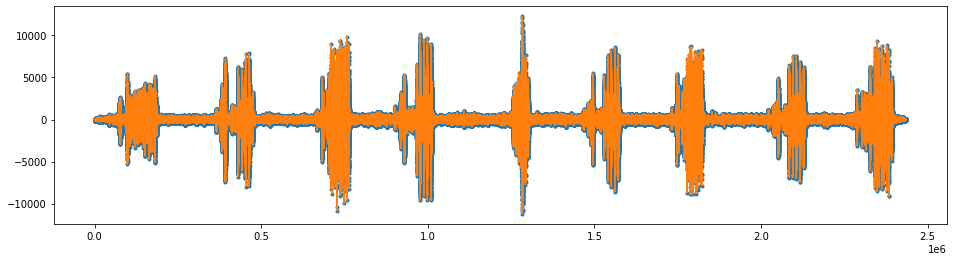

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(data, '.'); plt.plot(data, '-');

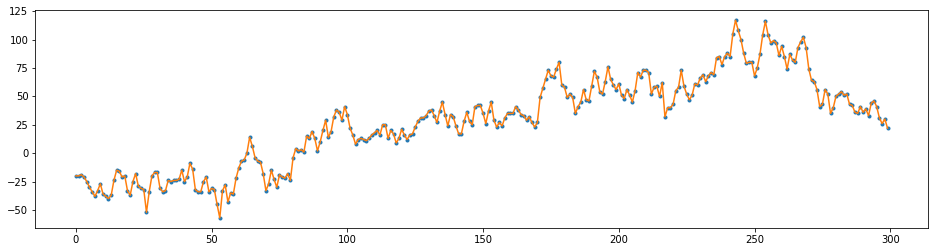

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(data[5000:5300], '.'); plt.plot(data[5000:5300], '-');

In [ ]:
#librosa
import librosa
y, sr = librosa.load(fname, mono=True)
print("Sampling (frame) rate = ", sr)
print("Total samples (frames) = ", y.shape)
print(y)

Sampling (frame) rate =  22050
Total samples (frames) =  (1217664,)
[-9.3409108e-06 -1.0015822e-05  3.4543725e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


Librosa uses a default sampling rate of 22050 if nothing is specified. You may be wondering, why 22050? Well, it’s the upper bound for the human hearing range. Humans can listen to frequencies ranging from 20 Hz to 20 KHz. That 20 KHz is 22050. 

A more common sampling rate is 44100 aka 44.1KHz, as described earlier.

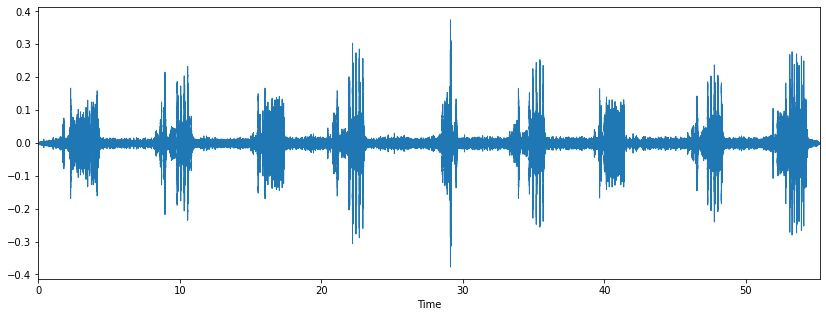

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

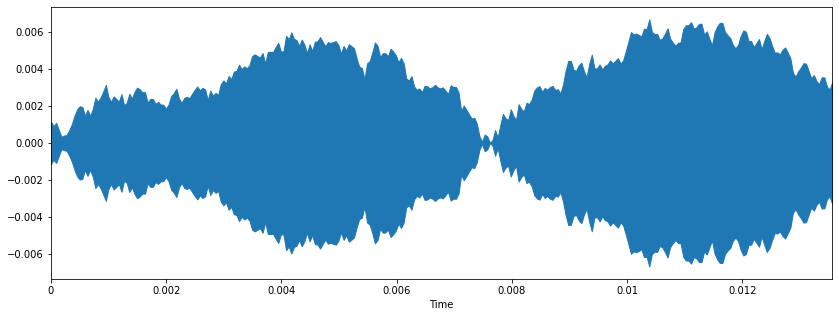

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y[5000:5300], sr=sr)

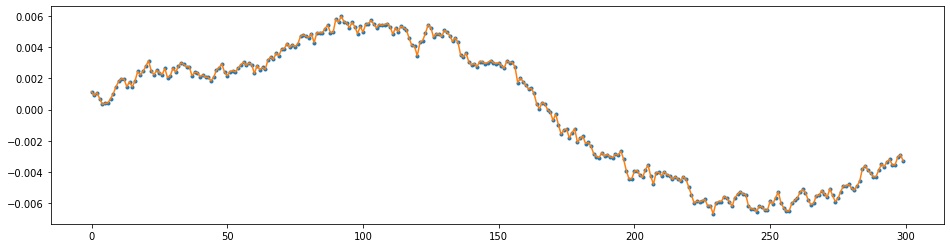

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(y[5000:5300], '.'); plt.plot(y[5000:5300], '-');

### Bit depth
Another important property -- bit depth.

Bit Rate and Bit Depth are two more important aspects of digitized sound. From the export (or render) window in your DAW, you will probably be able to choose from 16, 24, and 32 bit. This refers to Bit Depth – the number of possible values to represent a sample of the signal with. Professional studios usually offer bit depths of 24 and 32.

In digital multimedia, Bit Rate refers to the number of bits within a unit of playback time to represent a continuous medium (such as audio) and describes the character of the sample.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)


+ __Bit-depth = 16:__ The amplitude of each sample in the audio is one of 2^16 (=65536) possible values.

+ __Samplig rate = 44.1 kHz:__ Each second in the audio consists of 44100 samples. 


So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100*3.2 = 141120 values.

## Time to frequency aka. Fourier Transform

_A signal in the frequency domain requires much less computational space for storage._ --> [blogpost](https://towardsdatascience.com/ok-google-how-to-do-speech-recognition-f77b5d7cbe0b)

![](https://miro.medium.com/max/1706/0*jBBKMFymAHT5L3dn)


In [ ]:
from scipy.fftpack import fft
from scipy.signal import get_window #use hann window

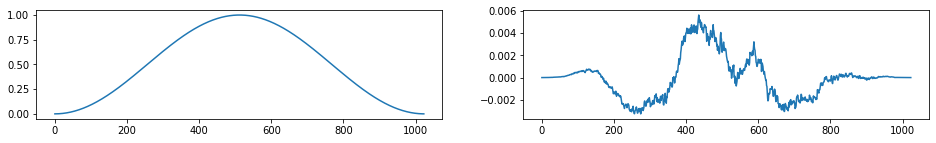

In [ ]:
frame_length = 1024
start = 5000

window = get_window("hann", frame_length)
x = y[start:start + frame_length]

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window); 
ax[1].plot(x * window);

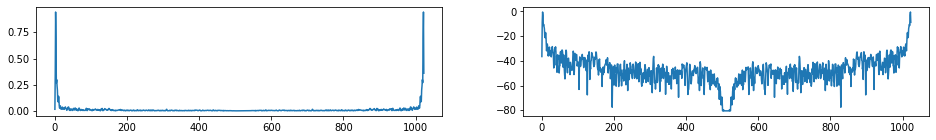

In [ ]:
fft_X = fft(x * window, frame_length)

X_magnitude, X_phase = librosa.magphase(fft_X)
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)


fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(X_magnitude);
ax[1].plot(X_magnitude_db);

Same, but already implemented for the whole audio signal.

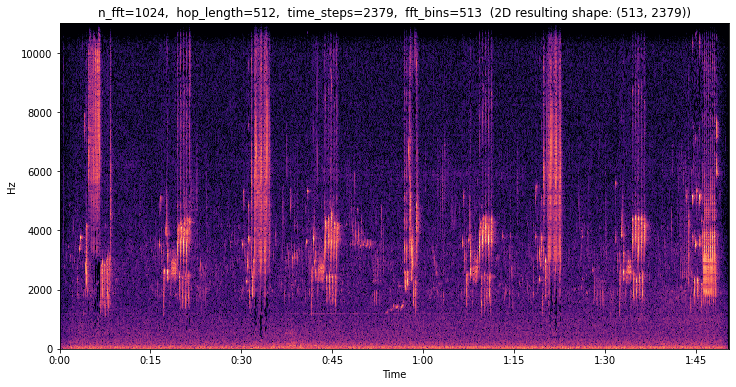

In [ ]:
import numpy as np

hop_length = 512

stft = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sr, hop_length=frame_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(frame_length, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

These are some of the reasons why many people use melspectrograms which transform the frequency bins into the mel scale. Librosa allows us to easily convert a regular spectrogram into a melspectrogram, and lets us define how many “bins” we want to have. We can also specify a minimum and maximum frequency that we want our bins to be divided into.


## Mel Spectograms

Read about them [here](https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial).

Mel-frequency cepstral coefficients (MFCCs)
Our voice/sound is dependent on the shape of our vocal tract including tongue, teeth etc. If we can determine this shape accurately, we can recognize the word/character being said. MFCC is a representation of the short-term power spectrum of a sound, which in simple terms represents the shape of the vocal tract.

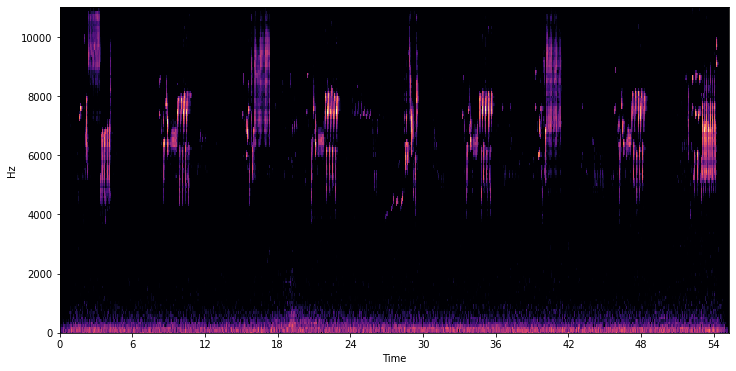

In [ ]:
# number of mel frequency bands 
n_mels = 64

melspec = librosa.feature.melspectrogram(y, sr=sr, hop_length=frame_length)
melspec_db = librosa.amplitude_to_db(melspec, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(melspec_db, x_axis='time', y_axis='linear', 
                         sr=sr, hop_length=frame_length)
#use librosa.feature.melspectrogram to build and show mfcc for different number  of mel frequency bands -- at least 2

## Hometask 1

(10 points)

Train and Evaluate Birds song classification using Spectograms/MelSpectograms and any classification engine you like.

_hints:_ 
+ you can try to use non neural approaches, such as logistic regression, random forest, xgboost __but__ on features build on sound -> simple waveforms, compressed spectograms, etc. 

+ you can try rnn on waves

+ you can try cnn (gans, etc, etc) on spectograms, melspectograms

(you don't have to design networks yourself, you can use `import torchvision.models as models` or any other code you'd like).


Implement at least 2 approaches and compare results on test samples.

In [ ]:
raise NotImplementedError

Sources:

https://www.klipsch.com/blog/digital-vs-analog-audio
https://wiki.hydrogenaud.io/index.php?title=File:Digital_wave.png
https://soundbridge.io/audio-formats-file-types/

